Credits to https://www.kaggle.com/allunia/pulmonary-dicom-preprocessing

I also used various Pytorch tutorials:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

https://pytorch.org/docs/stable/torchvision/models.html

Load the pretrained ResNeXt-101 model from Pytorch. This model hass already been trained to classify images using the ImageNet dataset.

In [73]:
import torchvision.models as models
resnext101 = models.resnext101_32x8d(pretrained=True, progress=True)

Let's print out the network just for fun. Note that there are lots of layers, we don't need to be worried with that. The only line we want to pay attention to for now is the last layer: (fc): Linear(in_features=2048, out_features=1000, bias=True)

That says that the network was able to boil the input images doen to 2048 features (floating point numbers). It then uses a fully-connected layer to convert the 2048 features into 1000 features. 

The final output of the netwrok is 1000 floating-point numbers. Each number is a score for a certain image label, and the highest score wins! So to get the prediction is index that has the maximum score.

In [74]:
resnext101

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [75]:
from __future__ import division
import argparse
import torch
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as T
import pandas as pd
import os
import pydicom
import numpy as np

Let's look at the training data. The training data is summarized in a CSV file. There's a lot of information. For now, let's pay attention to only the StudyInstanceUID and pe_present_on_image columns.

We want to reuse the resnext model to predict the pe_present_on_image column based on the image.

In [76]:
data_dir = '/projectnb/ece601/kaggle-pulmonary-embolism/rsna-str-pulmonary-embolism-detection/'
train_csv = data_dir + 'train.csv'
train_dir = data_dir + 'train/'

train = pd.read_csv(train_csv)

In [77]:
train.head()


,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


Define a dataset class.

In [78]:
class KagglePEDataset(torch.utils.data.Dataset):
    """Kaggle PE dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pedataframe = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        """ Return number of 2D images. (Each CT slice is an independent image.)"""
        return len(self.pedataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                train.StudyInstanceUID[idx],
                                train.SeriesInstanceUID[idx],
                                train.SOPInstanceUID[idx] + '.dcm')
        dicom_image = pydicom.dcmread(img_name) 
        image = dicom_image.pixel_array
        
        # in OSIC we find outside-scanner-regions with raw-values of -2000. 
        # Let's threshold between air (0) and this default (-2000) using -1000
        image[image <= -1000] = 0
        
        # convert to HU using DICOM information
        # HU is a number between -1000 and 1000 (generally)
        # good lung tissue is between -950 and -700 (approximately)
        intercept = dicom_image.RescaleIntercept
        slope = dicom_image.RescaleSlope
        
        if slope != 1:
            image = slope * image.astype(np.float64)
            
        image = image.astype(np.int16)
        image += np.int16(intercept)
    
        # image is 2D np array
        # pe_present_on_image is 0 or 1
        sample = {'image': image, 
                  'pe_present_on_image': int(train.pe_present_on_image[idx])}

        # Only apply transform to image.
        if self.transform:
            sample['image'] = self.transform(sample['image'])
            
        return sample

Define transform classes.

In [79]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        image = scipy.ndimage.interpolation.zoom(image, self.output_size/image.shape[0], mode='nearest')
        return image
    
class ToRGB(object):
    """
    Replicates a one channel (grayscale) image to make three channel (RGB) image
    """

    def __init__(self):
        pass

    def __call__(self, image):
        return np.stack((image,image,image),axis=-1).astype(np.float)

Instantiate a dataset object.

In [80]:
pe_dataset = KagglePEDataset(csv_file=train_csv, root_dir=train_dir)


In [81]:
pe_dataset[0]

{'image': array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16),
 'pe_present_on_image': 0}

In [82]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
from os import listdir
from matplotlib import pyplot as plt
import os
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader,Dataset

from skimage.color import gray2rgb
import functools
import torch
from tqdm.auto import tqdm
import pydicom
import seaborn as sns
import scipy
import PIL

Now that we've defined a dataset class, we can easily retrieve the image data.

Here I just randomly chose an image and plotted the image histogram (distribution of pixel intensities).

(512, 512)


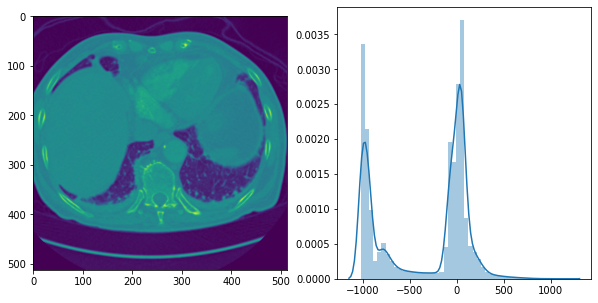

In [83]:
sample = pe_dataset[5]
print(sample['image'].shape)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(sample['image'])
sns.distplot(sample['image'].flatten(), ax=ax[1]);

For input into the neural network we don't want the image intensities to go between -1000 and 1000. We need to normalize.

In [84]:
PIL_image = PIL.Image.fromarray(sample['image'])
t = np.array(PIL_image).flatten()

# Calculate std and mean
print(np.std(t))
print(np.mean(t))

474.9254499504068
-341.86827087402344


In the plots below. We see the distributions before and after normalization. We've resized the image from 512x512 to 256x256 and normalized the pixel values to between -2 and 3, roughly.

We also convert the image to RGB (three channels) because that's what the network is expecting.

<PIL.Image.Image image mode=I size=512x512 at 0x2B80AE5DA7D0>


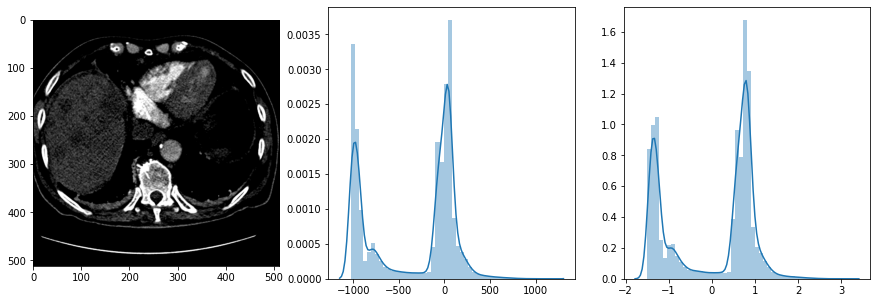

In [85]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(PIL_image)
sns.distplot(np.array(PIL_image).flatten(),ax=ax[1]);
print(PIL_image)

# use values from sample image (but ideally this should be values from entire dataset)
global_mean = -341.86827087402344
global_std = 474.9254499504068

transform=T.Compose([Rescale(256),
                     ToRGB(),
                     T.ToTensor(),
                     T.Normalize(mean=[global_mean, global_mean, global_mean], 
                                          std=[global_std, global_std, global_std]),
                    ])
sns.distplot(np.array(transform(sample['image'])),ax=ax[2]);

Now let's instantiate a transformed dataset using the transforms I gave above.

We see now the input is 3x256x256 tensor, and the values are relatively small. Now we're good to go!

In [86]:
transformed_dataset = KagglePEDataset(csv_file=train_csv, root_dir=train_dir,
                                           transform=transform)

In [87]:
sample = transformed_dataset[5]
print(sample['image'].shape)
print(sample['image'])

torch.Size([3, 256, 256])
tensor([[[-1.4363, -1.4363, -1.4363,  ..., -1.4363, -1.4363, -1.4363],
         [-1.4363, -1.4363, -1.4363,  ..., -1.4363, -1.4363, -1.4363],
         [-1.4363, -1.4363, -1.4363,  ..., -1.4363, -1.4363, -1.4363],
         ...,
         [-1.4363, -1.4363, -1.4363,  ..., -1.4363, -1.4363, -1.4363],
         [-1.4363, -1.4363, -1.4363,  ..., -1.4363, -1.4363, -1.4363],
         [-1.4363, -1.4363, -1.4363,  ..., -1.4363, -1.4363, -1.4363]],

        [[-1.4363, -1.4363, -1.4363,  ..., -1.4363, -1.4363, -1.4363],
         [-1.4363, -1.4363, -1.4363,  ..., -1.4363, -1.4363, -1.4363],
         [-1.4363, -1.4363, -1.4363,  ..., -1.4363, -1.4363, -1.4363],
         ...,
         [-1.4363, -1.4363, -1.4363,  ..., -1.4363, -1.4363, -1.4363],
         [-1.4363, -1.4363, -1.4363,  ..., -1.4363, -1.4363, -1.4363],
         [-1.4363, -1.4363, -1.4363,  ..., -1.4363, -1.4363, -1.4363]],

        [[-1.4363, -1.4363, -1.4363,  ..., -1.4363, -1.4363, -1.4363],
         [-1.4363, 

This line is just to instantiate a data loader from the transformed dataset. The important parameter here is batch size. We should tune this later.

In [88]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

Now, before we get going with our data. Let's verify that the pretrained network is working as advertised.

Out pretrained network is supposed to classify an image into 1000 groups. Let's get an image of a dog and put it into out network.

In [89]:
# Code from: https://pytorch.org/hub/pytorch_vision_resnext/

# sample execution (requires torchvision)
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)
    
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# paralleize model 
resnext101.cuda()
        
 # use network for evaluation 
resnext101.eval()

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    resnext101.to('cuda')

with torch.no_grad():
    output = resnext101(input_batch)

# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
print(torch.nn.functional.softmax(output[0], dim=0))

tensor([ 5.2828e-01, -3.3170e-01, -1.8014e+00, -2.6941e+00, -3.1607e+00,
         1.3930e+00, -1.1674e+00,  3.7893e+00,  5.6716e+00, -4.0214e-01,
        -2.1236e+00, -1.3128e+00, -1.4948e+00, -1.6140e+00, -1.7412e+00,
        -8.3268e-01, -1.1725e+00,  1.7003e-01, -3.1139e-01,  2.1723e-01,
        -1.8251e+00, -1.5743e+00, -1.3912e+00,  1.0092e+00, -1.1604e+00,
        -1.3435e+00, -1.3987e+00, -1.5336e+00, -1.0871e+00,  8.5892e-01,
        -2.1562e+00, -2.6454e+00, -1.7422e+00, -9.7604e-01, -4.0613e-01,
        -1.2835e+00, -1.1764e+00, -1.2384e-01, -1.4944e+00, -7.3944e-01,
        -2.5374e+00, -2.2302e+00, -2.1862e+00, -1.4216e+00, -1.5633e+00,
        -1.2318e+00, -1.4618e+00, -2.5462e+00, -1.0842e+00, -4.4718e-01,
        -4.7858e-01, -6.9786e-01,  7.4553e-01, -1.1112e+00, -8.1427e-01,
        -1.9938e+00, -9.0844e-02, -2.1621e+00, -1.8590e+00, -1.2367e+00,
         9.3756e-01, -7.7788e-01, -1.3797e+00, -9.0710e-01, -1.6186e+00,
        -2.2447e+00, -1.5728e+00, -1.5852e+00, -7.7

In [90]:
p = torch.nn.functional.softmax(output[0], dim=0).cpu()

# get the index with the highest score
itemindex = np.where(p == max(p))
print(itemindex)

(array([258]),)


The prediction is 258. Look this up in the label table @https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

258: 'Samoyed, Samoyede'

A Samoyed is the type of dog shown in the picture. So our model is working.

I wonder what the network thinks the lung CT scan looks like ... just for fun.

In [91]:
# The lung CT scan from above.
sample = transformed_dataset[5]
input_batch = sample['image'].float().unsqueeze(0) # create a mini-batch as expected by the model

# paralleize model 
resnext101.cuda()
        
 # use network for evaluation 
resnext101.eval()

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    resnext101.to('cuda')

with torch.no_grad():
    output = resnext101(input_batch)
    
p = torch.nn.functional.softmax(output[0], dim=0).cpu()

# get the index with the highest score
itemindex = np.where(p == max(p))
print(itemindex)

(array([896]),)


 896: 'washbasin, handbasin, washbowl, lavabo, wash-hand basin'
 
I can see the resemblance between the CT slice and a washbasin. Maybe the network picked up on the fact the image is oval-shaped. Not bad for a network that's never seen a CT scan before.

Now let's do something more meaningful. The network as is designed to classify into 1000 classes. We want the network to calssify into 2 classes (PE present, PE not present).

Remember that the last layer of ResNeXt takes 2048 inputs and outputs 1000 scores. We can replace that layer with a layer that takes 2048 inputs and outputs just 2 scores.

This is a very simple case of "transfer learning". The last layer of the network is not outputing something useful for me, but the previous layers of the network might be learning soemthing useful. So I chop off the last layer of the network and replace it.

In [92]:
resnext101.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [93]:
resnext101.fc = torch.nn.Linear(resnext101.fc.in_features, 2) # same number of input features, but just 2 output features

In [94]:
resnext101.fc

Linear(in_features=2048, out_features=2, bias=True)

Now I should have a model I can train on my data. I want to make sure it works first.

To test the model, let me just run 100 examples of the PE dataset through the network.

Note that the accuracy won't be good, because I haven't trained the model yet.

In [95]:
# paralleize model 
resnext101.cuda()
        
# use network for evaluation 
resnext101.eval()

testloader = DataLoader(transformed_dataset, batch_size=1, num_workers=1)
correct = 0

with torch.no_grad(): # Always call no_grad() when evaluating model (remove for training)
    for batch_idx, sample_batched in enumerate(testloader):
        data = torch.autograd.Variable(sample_batched['image'].cuda()), 
        target = torch.autograd.Variable(sample_batched['pe_present_on_image'].cuda())

        # forward
        output = resnext101(data[0].float())
        assert output.shape[1] == 2 # output shape is 1x2

        pred = output.data.max(1)[1]

        correct += pred.eq(target.data).sum()
        #print(correct)
        if batch_idx % 100 == 0 and batch_idx != 0:
            break
            # break early so I don't take forever, I'm just doing sanity check here.

In [96]:
print('accuracy on untrained model: ', correct.item()/batch_idx)

accuracy on untrained model:  0.57
